In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import FinanceDataReader as fdr
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
import statsmodels.api as sm
import itertools
from IPython.core.debugger import set_trace
from pykalman import KalmanFilter

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler#, Imputer
from sklearn.cluster import KMeans, DBSCAN

%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
univ = pd.read_excel('ticker_map.xlsx', converters={'code':str})
univ = list(univ['code']); univ;

In [6]:
_dflist = [fdr.DataReader(code, '2019-01-01') for code in tqdm(univ)]

  0%|          | 0/147 [00:00<?, ?it/s]

In [7]:
p = pd.concat([_s['Close'] for _s in _dflist], axis=1)
p.columns = univ
logp = np.log(p); logp.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-07,11.082143,10.911445,11.397515,13.511699,12.730801,13.478638,12.679196,12.128651,11.446786,12.172516,...,12.044729,11.297254,9.110520,9.623112,10.398946,9.519662,9.586720,9.485317,9.383032,11.628439
2023-04-10,11.092854,10.929529,11.415313,13.526494,12.745486,13.527828,12.741103,12.132964,11.451050,12.170445,...,12.041787,11.288531,9.098291,9.693384,10.408496,9.550733,9.593219,9.473858,9.385553,11.632485
2023-04-11,11.095894,10.920528,11.427368,13.550242,12.819906,13.599839,12.854484,12.165771,11.468974,12.205573,...,12.042377,11.286025,9.111624,9.771098,10.421537,9.567665,9.589804,9.476926,9.387649,11.631153
2023-04-12,11.097410,10.925938,11.410893,13.546323,12.809022,13.560618,12.840000,12.197032,11.491702,12.196022,...,12.020947,11.261897,9.120416,9.751501,10.424659,9.545025,9.604070,9.484177,9.390159,11.630531
2023-04-13,11.097410,10.918718,11.403111,13.545013,12.807653,13.602317,12.889169,12.196022,11.485554,12.187399,...,12.018538,11.267025,9.121509,9.756726,10.425550,9.545741,9.621788,9.484557,9.390576,11.628217


In [8]:
p_open = pd.concat([_s['Open'] for _s in _dflist], axis=1)
p_open.columns = univ; p_open.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-07,63800,54100,87900,742000,340000,720000,321000,185400,94300,193000,...,171100,80200,8950,15090,32510,13210,14630,13115,11920,113300
2023-04-10,64800,54700,88700,738000,338500,721000,326000,186000,94000,193300,...,170200,80900,9050,15380,32805,13625,14680,13090,11910,112310
2023-04-11,66200,56000,90700,756000,357000,768000,390000,186600,94100,193300,...,170200,79300,8940,17520,33235,14165,14500,13005,11920,112695
2023-04-12,65800,55300,91900,776000,374500,799000,401500,195000,96000,199300,...,170100,79800,9100,17610,33540,14305,14780,13080,11940,112550
2023-04-13,65600,55100,89500,753000,365500,760000,369000,199000,97800,196200,...,165200,77800,9120,17180,33515,13780,15065,13155,11950,112480


<AxesSubplot:xlabel='Date'>

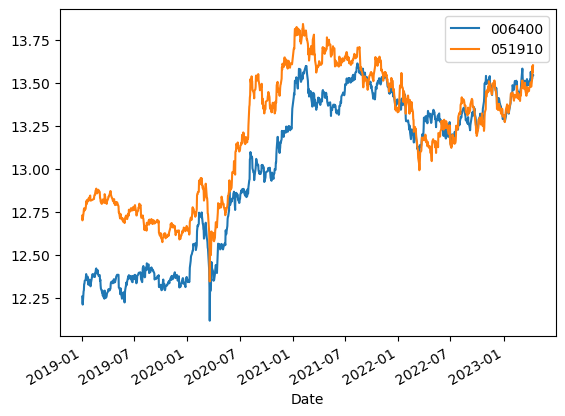

In [368]:
a0, a1 = '006400', '051910'
x = logp[a0]#.diff().fillna(0).cumsum()
y = logp[a1]#.diff().fillna(0).cumsum()
#logp[[a0, a1]].plot()
x.plot(legend=True)
y.plot(legend=True)

In [353]:
x.shape

(1059,)

C:\Users\USER\AppData\Local\Temp\ipykernel_10640\2125577369.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])


Text(0, 0.5, 'y')

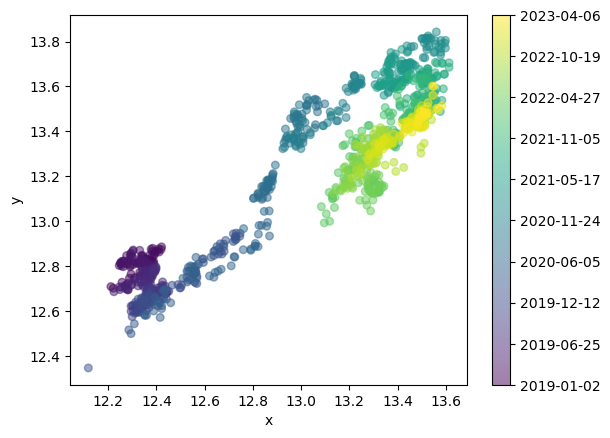

In [369]:
colors = np.linspace(0.1, 1, len(x))
sc = plt.scatter(x, y, s=30, c=colors, alpha=0.5)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
plt.xlabel('x')
plt.ylabel('y')

In [316]:
# delta = 1e-2
# trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
# obs_mat = sm.add_constant(x.values, prepend=False)[:, np.newaxis]
# #obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

# kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
#                   initial_state_mean=[1,0],
#                   initial_state_covariance=np.ones((2, 2)),
#                   transition_matrices=np.eye(2),
#                   observation_matrices=obs_mat,
#                   observation_covariance=1,
#                   transition_covariance=trans_cov)

In [370]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(1) # How much random walk wiggles
obs_mat = x.values[:, np.newaxis][:, np.newaxis]

kf = KalmanFilter(n_dim_obs=1, n_dim_state=1, 
                  initial_state_mean=[1],
                  initial_state_covariance=np.ones((1, 1)),
                  transition_matrices=np.eye(1),
                  observation_matrices=obs_mat,
                  observation_covariance=1,
                  transition_covariance=trans_cov)

In [371]:
# Use the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(y.values)

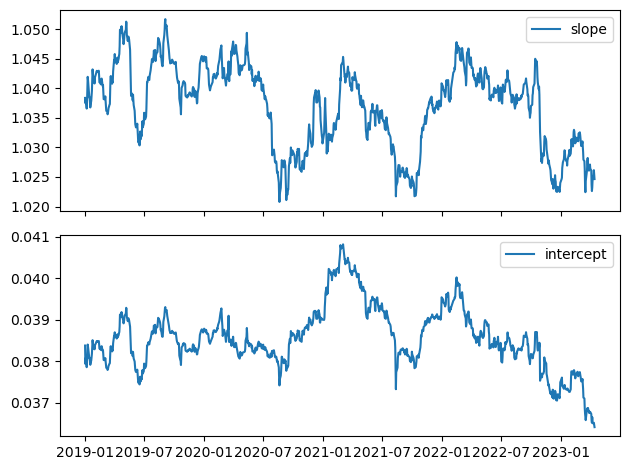

In [168]:
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, state_means[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(x.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

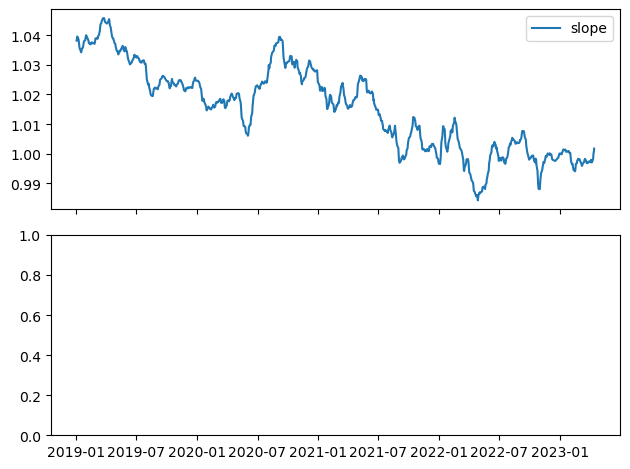

In [372]:
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, state_means[:,0], label='slope')
axarr[0].legend()
plt.tight_layout();

In [15]:
beta = state_means[:,0]
intercept = state_means[:,1]

In [290]:
data = logp[[a0, a1]]#.diff().fillna(0).cumsum()
p_data = p[[a0, a1]]
p_open_data = p_open[[a0, a1]]

<AxesSubplot:xlabel='Date'>

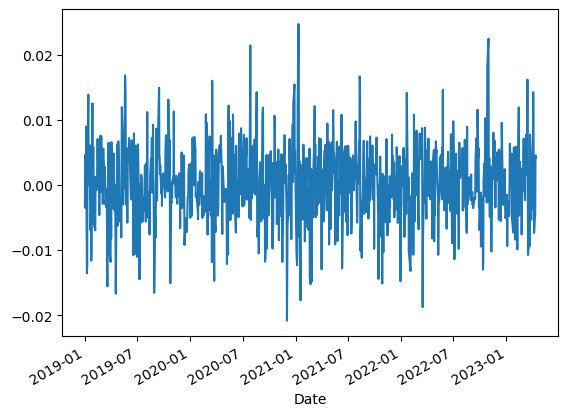

In [17]:
sp = beta*x + intercept - y
sp.plot()

<AxesSubplot:xlabel='Date'>

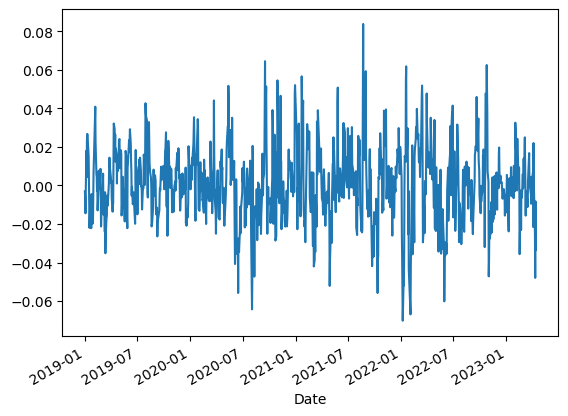

In [373]:
data = logp[[a0, a1]]#.diff().fillna(0).cumsum()
p_data = p[[a0, a1]]
p_open_data = p_open[[a0, a1]]

beta = state_means[:,0]
sp = beta*x - y
sp.plot()

In [18]:
beta.shape

(1059,)

In [366]:
def getStrategyPortfolioWeights2(rolling_beta, stock_name1, stock_name2, data, smoothing_window=15):
    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    
    signal_spot = pd.Series(np.zeros(data1.shape[0]), index=data.index)
    
    for i in range(smoothing_window, data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]
        
        # dynamically rebalance the signal when not trading
        fixed_beta = float(rolling_beta[i])
        signal = fixed_beta*data1 - data2
        smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
        d_smoothed_signal = smoothed_signal.diff()
        thres = pd.Series(signal).rolling(20, min_periods=1).std()

        signal_spot[i] = smoothed_signal[i]
        
        if trading=="not":

            if smoothed_signal[i] > 0.2*thres[i] and d_smoothed_signal[i] < 0:
                w0 = -fixed_beta / (abs(fixed_beta)+1)
                w1 = 1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = w0 / w_max #np.sign(w0 / w_max)
                leverage.iloc[i,1] = w1 / w_max #np.sign(w1 / w_max)
                                
                trading = "short"
                trading_start = smoothed_signal[i]
                
            elif smoothed_signal[i] < -0.2*thres[i] and d_smoothed_signal[i] > 0:
                w0 = fixed_beta / (abs(fixed_beta)+1)
                w1 = -1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = w0 / w_max
                leverage.iloc[i,1] = w1 / w_max
                                
                trading = "long"
                trading_start = smoothed_signal[i]                
                
            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                
        elif trading=="long":
            # a failed trade
            #if smoothed_signal[i] < trading_start:
            if smoothed_signal[i] < -1.1*thres[i]:    
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] > 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
        elif trading=="short":
            signal_spot[i] = smoothed_signal[i]
            
            # a failed trade
            #if smoothed_signal[i] > trading_start:
            if smoothed_signal[i] > 1.1*thres[i]:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] < 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage.fillna(0), signal_spot

In [292]:
def getStrategyPortfolioWeights(rolling_beta, stock_name1, stock_name2, data, smoothing_window=15):
    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    
    signal_spot = pd.Series(np.zeros(data1.shape[0]), index=data.index)
    
    for i in range(smoothing_window, data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":
            # dynamically rebalance the signal when not trading
            fixed_beta = float(rolling_beta[i])
            signal = fixed_beta*data1 - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()
            thres = pd.Series(signal).rolling(20, min_periods=1).std()

            signal_spot[i] = smoothed_signal[i]

            if smoothed_signal[i] > 0.3*thres[i] and d_smoothed_signal[i] < 0:
                w0 = -fixed_beta / (abs(fixed_beta)+1)
                w1 = 1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = w0 / w_max #np.sign(w0 / w_max)
                leverage.iloc[i,1] = w1 / w_max #np.sign(w1 / w_max)
                                
                trading = "short"
                trading_start = smoothed_signal[i]
                
            elif smoothed_signal[i] < -0.3*thres[i] and d_smoothed_signal[i] > 0:
                w0 = fixed_beta / (abs(fixed_beta)+1)
                w1 = -1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = w0 / w_max
                leverage.iloc[i,1] = w1 / w_max
                                
                trading = "long"
                trading_start = smoothed_signal[i]                
                
            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                
        elif trading=="long":
            # a failed trade
            #if smoothed_signal[i] < trading_start:
            if smoothed_signal[i] < -1.1*thres[i]:    
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] > 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
        elif trading=="short":
            signal_spot[i] = smoothed_signal[i]
            
            # a failed trade
            #if smoothed_signal[i] > trading_start:
            if smoothed_signal[i] > 1.1*thres[i]:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] < 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage.fillna(0), signal_spot

In [293]:
def backtest(pricingDF, openDF, leverageDF, start_cash):
    pricing = pricingDF.values
    pricing_open = openDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = cash[1] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    
    total_cost = 0
    pnl_hist = np.zeros(pricing.shape[0])
    pnl = []
    values = np.zeros(pricing.shape[0])
    values[0] = values[1] = start_cash

    
    for t in range(2, pricing.shape[0]):
        if np.any(leverage[t-1] != leverage[t-2]):
            target_shares = (start_cash * leverage[t-1] / pricing[t-1]).astype(int)
            
            # rebalance
            shares[t] = target_shares
            cost0 = abs(shares[t,0] - shares[t-1,0]) * pricing_open[t,0] * 0.0001
            cost1 = abs(shares[t,1] - shares[t-1,1]) * pricing_open[t,1] * 0.0001

            cash[t] = cash[t-1] - ((shares[t]-shares[t-1]) * pricing_open[t]).sum() - cost0 - cost1
            total_cost += (cost0 + cost1)
            
        else:
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
            
        values[t] = (shares[t] * pricing[t]).sum() + cash[t]
            
        if shares[t-1,0]==0 and shares[t,0]!=0:
            pnl_hist[t] = values[t] - values[t-1]
            
        elif shares[t,0]!=0 or (shares[t-1,0]!=0 and shares[t,0]==0):
            pnl_hist[t] = pnl_hist[t-1] + values[t] - values[t-1]
            
        if shares[t-1,0]!=0 and shares[t,0]==0:
            pnl.append(pnl_hist[t])
    
    
    pct_returns = (values - start_cash) / start_cash
    
    n_days = pct_returns.shape[0]
    net_profit = int(values[-1] - start_cash)
    net_return = pct_returns[-1] * 100
    total_cost_rate = total_cost / (net_profit + total_cost) * 100
    n_entry = len(pnl)
    n_entry_monthly = n_entry / n_days * 20
    n_entry_days = (leverageDF.iloc[:,0] != 0).sum()
    n_holding_days = n_entry_days / n_entry
    pnl_by_entry = net_profit / n_entry
    profit_of_profit_entry = np.mean(list(filter(lambda x: x>0, pnl)))
    loss_of_loss_entry = np.mean(list(filter(lambda x: x<0, pnl)))

    print(f'테스트 일수: {n_days}일')
    print(f'순손익 (투자금액대비%): {format(net_profit, ",")}원 ({net_return:.3f}%)')
    print(f'총비용 (총손익대비%): {format(int(total_cost), ",")}원 ({total_cost_rate:.3f}%)')
    print(f'진입횟수: {n_entry}회')
    print(f'월평균 진입횟수: {n_entry_monthly:.2f}회')
    print(f'진입일수 (전체일수대비%): {n_entry_days}일 ({n_entry_days/n_days*100:.2f}%)')
    print(f'평균보유일수: {n_holding_days:.2f}일')
    print(f'진입당 평균손익: {format(int(pnl_by_entry), ",")}원')
    print(f'최대수익: {format(int(max(pnl)), ",")}원')
    print(f'최대손실: {format(int(min(pnl)), ",")}원')
    #print(f'수익진입의 평균수익: {format(int(profit_of_profit_entry), ",")}원')
    #print(f'손실진입의 평균손실: {format(int(loss_of_loss_entry), ",")}원')
    
    return (
        pd.DataFrame(shares, index=pricingDF.index, columns=pricingDF.columns),
        pd.Series(cash, index=pricingDF.index),
        pd.Series(pct_returns, index=pricingDF.index),
        pd.Series(values, index=pricingDF.index),
        pd.Series(pnl_hist, index=pricingDF.index),
        pd.Series(pnl)
    )

테스트 일수: 1059일
순손익 (투자금액대비%): 61,149,088원 (61.149%)
총비용 (총손익대비%): 2,988,811원 (4.660%)
진입횟수: 76회
월평균 진입횟수: 1.44회
진입일수 (전체일수대비%): 220일 (20.77%)
평균보유일수: 2.89일
진입당 평균손익: 804,593원
최대수익: 6,955,492원
최대손실: -6,328,669원


<AxesSubplot:xlabel='Date'>

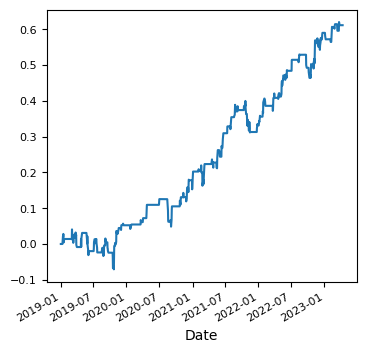

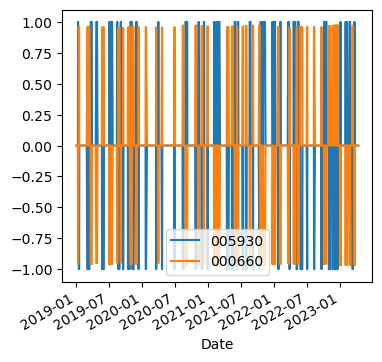

In [312]:
w5, signal5 = getStrategyPortfolioWeights(beta, a0, a1, data, smoothing_window=1)
shares5, cash5, returns5, values5, pnl_hist5, pnl5 = backtest(p_data, p_open_data, w5, 1e8)
returns5.plot(figsize=(4,4), fontsize=8)
w5.plot(figsize=(4,4), fontsize=10)

테스트 일수: 1059일
순손익 (투자금액대비%): 9,192,310원 (9.192%)
총비용 (총손익대비%): 3,351,189원 (26.717%)
진입횟수: 84회
월평균 진입횟수: 1.59회
진입일수 (전체일수대비%): 329일 (31.07%)
평균보유일수: 3.92일
진입당 평균손익: 109,432원
최대수익: 7,166,556원
최대손실: -16,898,140원


<AxesSubplot:xlabel='Date'>

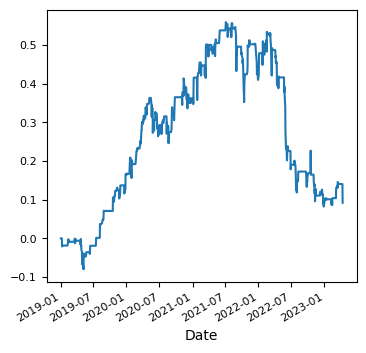

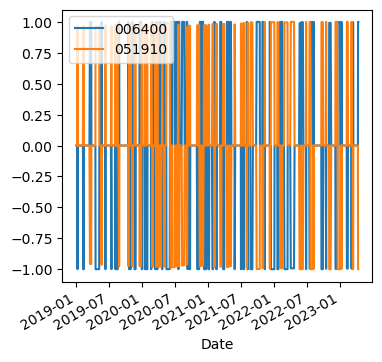

In [374]:
w5, signal5 = getStrategyPortfolioWeights2(beta, a0, a1, data, smoothing_window=1)
shares5, cash5, returns5, values5, pnl_hist5, pnl5 = backtest(p_data, p_open_data, w5, 1e8)
returns5.plot(figsize=(4,4), fontsize=8)
w5.plot(figsize=(4,4), fontsize=10)

In [347]:
w5.tail(30)

,000660,005930
Date,,
2023-03-03,0.000000,0.0
2023-03-06,0.000000,0.0
2023-03-07,0.000000,0.0
2023-03-08,0.000000,0.0
2023-03-09,0.000000,0.0
2023-03-10,0.000000,0.0
2023-03-13,0.968895,-1.0
2023-03-14,0.000000,0.0
2023-03-15,0.000000,0.0


<AxesSubplot:xlabel='Date'>

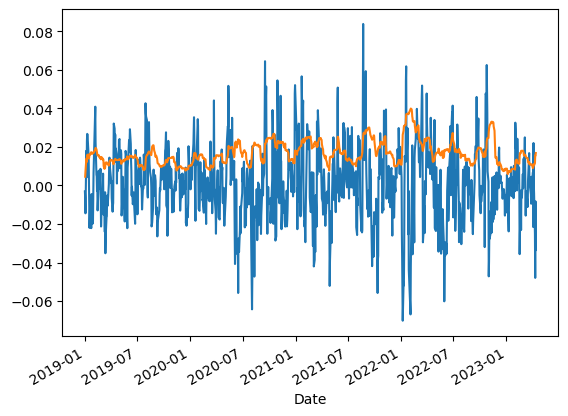

In [376]:
# signal5.plot()
(beta*x - y).plot()
signal5.rolling(20, min_periods=1).std().plot()

In [37]:
signal5.head(6)

Date
2019-01-02    0.000000
2019-01-03    0.004629
2019-01-04   -0.009863
2019-01-07    0.018703
2019-01-08   -0.006136
2019-01-09   -0.037762
dtype: float64

In [38]:
sp = beta*x + intercept - y
sp.head(6)

Date
2019-01-02   -0.003319
2019-01-03    0.004629
2019-01-04   -0.003511
2019-01-07    0.009001
2019-01-08   -0.006136
2019-01-09   -0.013553
dtype: float64

In [40]:
w5.head(6)

,005930,000660
Date,,
2019-01-02,0.0,0.000000
2019-01-03,1.0,-0.963865
2019-01-04,1.0,-0.963865
2019-01-07,0.0,0.000000
2019-01-08,-1.0,0.963763
2019-01-09,0.0,0.000000


<AxesSubplot:xlabel='Date'>

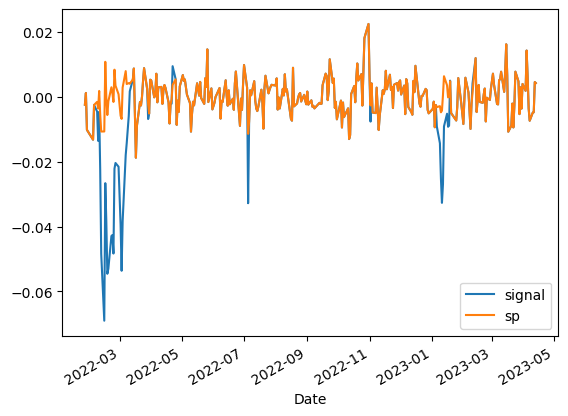

In [87]:
pd.DataFrame({'signal': signal5, 'sp': beta*x + intercept - y}).tail(300).plot()

In [76]:
stock_name1 = a0
stock_name2 = a1
smoothing_window = 1


data1 = data[stock_name1]#.ffill().fillna(0).values
data2 = data[stock_name2]#.ffill().fillna(0).values

trading = "not"
trading_start = 0
leverage = 0*data.copy()
signal_spot = pd.Series(np.zeros(data1.shape[0]), index=data.index)

for i in range(smoothing_window, data1.shape[0]):
    if i==5: set_trace()
    leverage.iloc[i,:] = leverage.iloc[i-1,:]

    if trading=="not":
        # dynamically rebalance the signal when not trading
        fixed_beta = float(beta[i])
        fixed_intercept = float(intercept[i])
        signal = fixed_beta*data1 + fixed_intercept - data2
        smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
        thres = pd.Series(signal).rolling(20, min_periods=1).std()
        d_smoothed_signal = smoothed_signal.diff()
        signal_spot[i] = smoothed_signal[i]

        if smoothed_signal[i-1] > thres[i] and d_smoothed_signal[i] < 0:
            w0 = -fixed_beta / (abs(fixed_beta)+1)
            w1 = 1 / (abs(fixed_beta)+1)

            w_max = max(abs(w0), abs(w1))

            leverage.iloc[i,0] = w0 / w_max
            leverage.iloc[i,1] = w1 / w_max

            trading = "short"
            trading_start = smoothed_signal[i]

        elif smoothed_signal[i-1] < -thres[i] and d_smoothed_signal[i] > 0:
            w0 = fixed_beta / (abs(fixed_beta)+1)
            w1 = -1 / (abs(fixed_beta)+1)

            w_max = max(abs(w0), abs(w1))

            leverage.iloc[i,0] = w0 / w_max
            leverage.iloc[i,1] = w1 / w_max

            trading = "long"
            trading_start = smoothed_signal[i]

        else:
            leverage.iloc[i,0] = 0
            leverage.iloc[i,1] = 0

    elif trading=="long":
        signal_spot[i] = smoothed_signal[i]

        # a successful trade
        if smoothed_signal[i] > 0:
            leverage.iloc[i,0] = 0
            leverage.iloc[i,1] = 0
            trading = "not"

    elif trading=="short":
        signal_spot[i] = smoothed_signal[i]

        # a successful trade
        if smoothed_signal[i] < 0:
            leverage.iloc[i,0] = 0
            leverage.iloc[i,1] = 0
            trading = "not"
            
leverage.head(6)

None
> c:\users\user\appdata\local\temp\ipykernel_10640\4187568576.py(16)<module>()

ipdb> l
     11 leverage = 0*data.copy()
     12 signal_spot = pd.Series(np.zeros(data1.shape[0]), index=data.index)
     13 
     14 for i in range(smoothing_window, data1.shape[0]):
     15     if i==5: set_trace()
---> 16     leverage.iloc[i,:] = leverage.iloc[i-1,:]
     17 
     18     if trading=="not":
     19         # dynamically rebalance the signal when not trading
     20         fixed_beta = float(beta[i])
     21         fixed_intercept = float(intercept[i])

ipdb> n
None
> c:\users\user\appdata\local\temp\ipykernel_10640\4187568576.py(18)<module>()

ipdb> n
None
> c:\users\user\appdata\local\temp\ipykernel_10640\4187568576.py(56)<module>()

ipdb> l
     51 
     52         else:
     53             leverage.iloc[i,0] = 0
     54             leverage.iloc[i,1] = 0
     55 
---> 56     elif trading=="long":
     57         signal_spot[i] = smoothed_signal[i]
     58 
     59         # a su

BdbQuit: 